<img src="https://raw.githubusercontent.com/earthdaily/Images/main/Corporate/EarthDaily.png" width="20%" alt="EarthDaily Analytics">

# Working with EarthDaily DataCubes
__________________
<a href="https://earthdaily.com/contact/">Give Feedback</a> | <a href="https://github.com/earthdaily">Bug report</a>

**Tags:** #EDS, #EarthMosaics, #EarthDailyConstellation, #EDC, #EarthDailyPython

**Authors**: EarthDaily Analytics

**Last update:** 2024-12-23 (Created: 2024-12-23)

**References:**
- [Earth Daily package](https://github.com/earthdaily/earthdaily-python-client)
- [Earth Data Store documentation](https://earthdaily.github.io/EDA-Documentation/)

## Introduction
EarthDaily Analytics offers access to several [STAC-compliant](https://stacspec.org/en) catalogs of raster data, such as [EarthMosaics](https://earthdaily.com/product-service/earthmosaics/) and [VENuS](https://earthdaily.com/earthdaily-ven%C2%B5s-l2a-cloud-optimized-geotiffs/), as well as maintains development of the [EarthDaily Python Client](https://pypi.org/project/earthdaily/), which acts as a user-friendly access interface to retrieve pixel data as [xarray](https://docs.xarray.dev/en/stable/) objects. Furthermore, xarray datasets returned through the EarthDaily Python Client have several unique features and functionality improvements for convenient remote sensing shorthand analysis. 

## Objectives
This notebook covers details and methods specific to datasets retrieved from the EarthDaily Earth Data Store, covering:
* Native index calculations
* Plotting features
* Zonal Statistics

Import dependencies

In [1]:
import earthdaily
from earthdaily.earthdatastore import datacube
from earthdaily import EarthDataStore

In [2]:
import os
import requests
from dotenv import load_dotenv
from shapely.geometry import box

import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

### Connecting to EarthDataStore

Loading in environment variables, please update the associated [`EDS.env`](EDS.env), which can be downloaded from the [EarthDaily Account Management page](https://console.earthdaily.com/account).

In [3]:
load_dotenv("EDS.env")

True

In [4]:
eds = EarthDataStore()

### Search for Imagery

In [5]:
bbox = [-52.38175462, -29.85496458, -52.07547469, -29.61356083]
start_date = "2024-02-01"
end_date = "2024-12-01"

gdf = gpd.GeoDataFrame(
    {'geometry':[box(*bbox)]}, 
    crs='epsg:4326'
)

> _**Note:**_ Here we import a small utility function which replaces S3 HREFs with public HTTPS URLs.

In [6]:
from utils import replace_alternate_href

In [7]:
items = eds.search(
    collections=["ai-ready-mosaics-sample"],
    datetime=f"{start_date}/{end_date}",
    bbox=bbox
)
# Apply href function
[replace_alternate_href(item) for item in items]
print(f'Found unique {len(items)} items' )
items

Found unique 2 items


### Retrieve DataCube

In [8]:
ds = datacube(
    items,
    assets=("red", "green", "blue", "nir08"),
    intersects=gdf,
    crs="epsg:3857", 
    resolution=10.,
    bbox=bbox,
    chunks={"x": 2048, "y": 2048},
)
ds

<xarray.Dataset> Size: 338MB
Dimensions:      (y: 3095, x: 3409, time: 2)
Coordinates:
  * y            (y) float64 25kB -3.454e+06 -3.454e+06 ... -3.485e+06
  * x            (x) float64 27kB -5.831e+06 -5.831e+06 ... -5.797e+06
  * time         (time) datetime64[ns] 16B 2024-02-21T13:40:29.936000 2024-05...
    spatial_ref  int64 8B 0
Data variables:
    red          (time, y, x) float32 84MB dask.array<chunksize=(1, 2048, 2047), meta=np.ndarray>
    green        (time, y, x) float32 84MB dask.array<chunksize=(1, 2048, 2047), meta=np.ndarray>
    blue         (time, y, x) float32 84MB dask.array<chunksize=(1, 2048, 2047), meta=np.ndarray>
    nir08        (time, y, x) float32 84MB dask.array<chunksize=(1, 2048, 2047), meta=np.ndarray>

# EarthDaily Accessor Datasets
Xarray Datasets returned from the EarthDaily Python Client are serialized with enhanced features, accessible through the associated `EarthDailyAccessorDataset` as shown below:

In [9]:
type(ds.ed)

earthdaily.accessor.EarthDailyAccessorDataset

### Plotting RGB
These objects include convenient plotting functionality, such as `plot_rgb`:

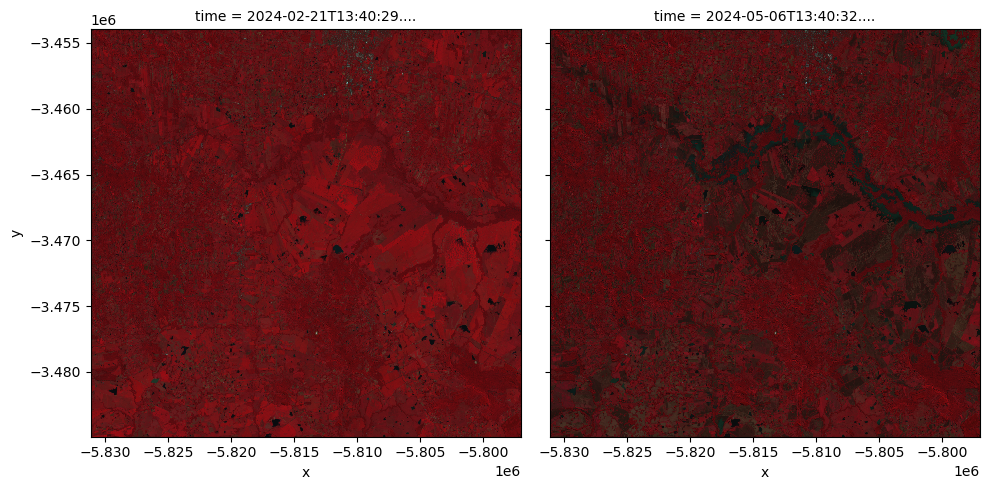

/home/ubuntu/miniconda3/envs/earthdaily/lib/python3.12/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [10]:
ds.ed.plot_rgb(red='nir08', green='red', blue='green', figsize=(10,5))

### Index Calculation
These objects also utilize the [Spyndex API](https://spyndex.readthedocs.io/en/latest/reference.html#spyndex-spyndex), allowing for clean index calculations based off the available bands in each dataset:

In [11]:
ds.ed.available_indices()

['BCC',
 'BITM',
 'BIXS',
 'DSWI4',
 'ExG',
 'ExGR',
 'ExR',
 'GCC',
 'GLI',
 'IKAW',
 'MGRVI',
 'MRBVI',
 'NDGlaI',
 'NDTI',
 'NDYI',
 'NGRDI',
 'OSI',
 'RCC',
 'RGBVI',
 'RGRI',
 'RI',
 'RI4XS',
 'SI',
 'TGI',
 'VARI',
 'VIG']

Add NDVI band to the dataset in a single call:

In [12]:
ds = ds.ed.add_indices(['NDVI'], N=ds['nir08'], R=ds['red'])

### Plotting Single-Band Imagery
Use the `plot_band` method for inspecting single-band images:

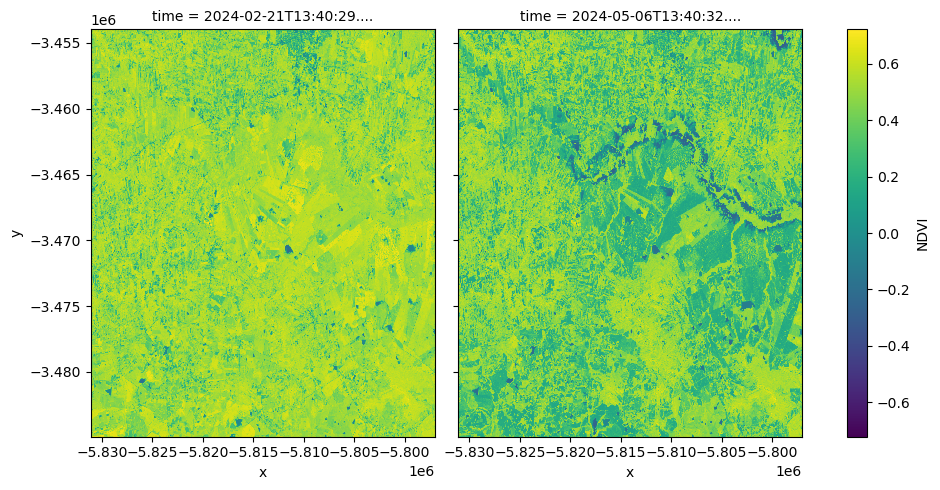

In [13]:
ds.ed.plot_band('NDVI', figsize=(10, 5), cmap='viridis')

### Zonal Statistics
Use the `zonal_stats` method to compute basic summary statistics for a given index:

In [14]:
ds_mean = ds.ed.zonal_stats(gdf)

In [15]:
ds_mean['NDVI'].to_numpy()

array([[[0.49983495]],

       [[0.3728453 ]]], dtype=float32)

In [ ]:
## TODO: Mask polygons - NDVI over fields, reference more advanced use cases in markdown